In [16]:
# NOTE: NEED TO RERUN WITH NEW ERROR SETTINGS (AND ALSO INCREASE SIGNAL SIZE)

In [1]:
import numpy as np
import scipy.stats
import pandas as pd

import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")
from chiseling.dgps.heterogeneous_linear_rct import HeterogeneousLinearRCT

### Formatting

In [2]:
# FORMATTING SETTINGS HERE

### Preprocessing

In [3]:
task_array_path = "../../task_arrays/heterogeneous_linear_rct_ridgecv.tasks.tsv"
res_path = "../../../output/heterogeneous_linear_rct_ridgecv/heterogeneous_linear_rct_ridgecv.combined.tsv"

In [4]:
task_df = pd.read_csv(task_array_path, sep="\t", index_col=None)
res_df = pd.read_csv(res_path, sep="\t", index_col=None)
# Merge task meta and results
res_df = res_df.merge(task_df, how="left", on="task_id")

In [5]:
# Aggregate results
setting_identifiers = ["n", "theta", "tau", "subgroup_size", "strategy", "margin_width",
                       "n_burn_in", "train_ratio", "bonf_strategy"]
agg_res_df = res_df.groupby(setting_identifiers, dropna=False)[["rejected", "subgroup_utility", "region_mass"]].agg(["mean", "var", "count"])
agg_res_df.columns = ["_".join(c) for c in agg_res_df.columns.to_flat_index()]
agg_res_df = agg_res_df.reset_index()
agg_res_df["rejected_se"] = np.sqrt(agg_res_df.rejected_var / agg_res_df.rejected_count)
agg_res_df["subgroup_utility_se"] = np.sqrt(agg_res_df.subgroup_utility_var / agg_res_df.subgroup_utility_count)
agg_res_df["region_mass_se"] = np.sqrt(agg_res_df.region_mass_var / agg_res_df.region_mass_count)
agg_res_df = agg_res_df.loc[:,setting_identifiers + ["rejected_mean", "rejected_se",
                                                     "subgroup_utility_mean", "subgroup_utility_se",
                                                     "region_mass_mean", "region_mass_se"]]

In [6]:
# Drop simultaneous because it's not really valid
# agg_res_df = agg_res_df[agg_res_df.strategy != "SimulDataSplittingStrategy"]
# agg_res_df = agg_res_df[agg_res_df.bonf_strategy != "SimulDataSplittingStrategy"]

PLOT_SIMUL = True

### Settings

In [7]:
# size, n, theta, tau
dgp_settings = [(0.5, 1000, 0.4, 0),
                (0.25, 2000, 0.4, -0.320),
                (0.1, 5000, 0.3, -0.450),
                (0.05, 10000, 0.4, -0.772),
                (0.01, 25000, 0.5, -1.375)]
margin_width_settings = [0, 0.5, 1]

### Standardize by optimal region utilities

In [8]:
# Hyperparameters
d = 100
s = 5
rho = 0.2

test_thresh = 0
random_seed = 42

In [9]:
# utility, size, mean, and standard errors
opt_region_metrics_dict = {}
for (subgroup_size, n, theta, tau) in dgp_settings:
    sampler = HeterogeneousLinearRCT(d, s, rho, theta, tau, random_seed=random_seed)
    opt_region_metrics = sampler.get_optimal_region_metrics()
    opt_region_metrics_dict[(theta, tau)] = opt_region_metrics

In [10]:
# Calculate normalized utilities
agg_res_df["opt_utility"] = agg_res_df.apply(lambda row:
                                             opt_region_metrics_dict[(row.theta, row.tau)][0],
                                             axis=1)
agg_res_df["norm_subgroup_utility_mean"] = (agg_res_df["subgroup_utility_mean"] /
                                            agg_res_df["opt_utility"])

### Visualizations

Expected utility

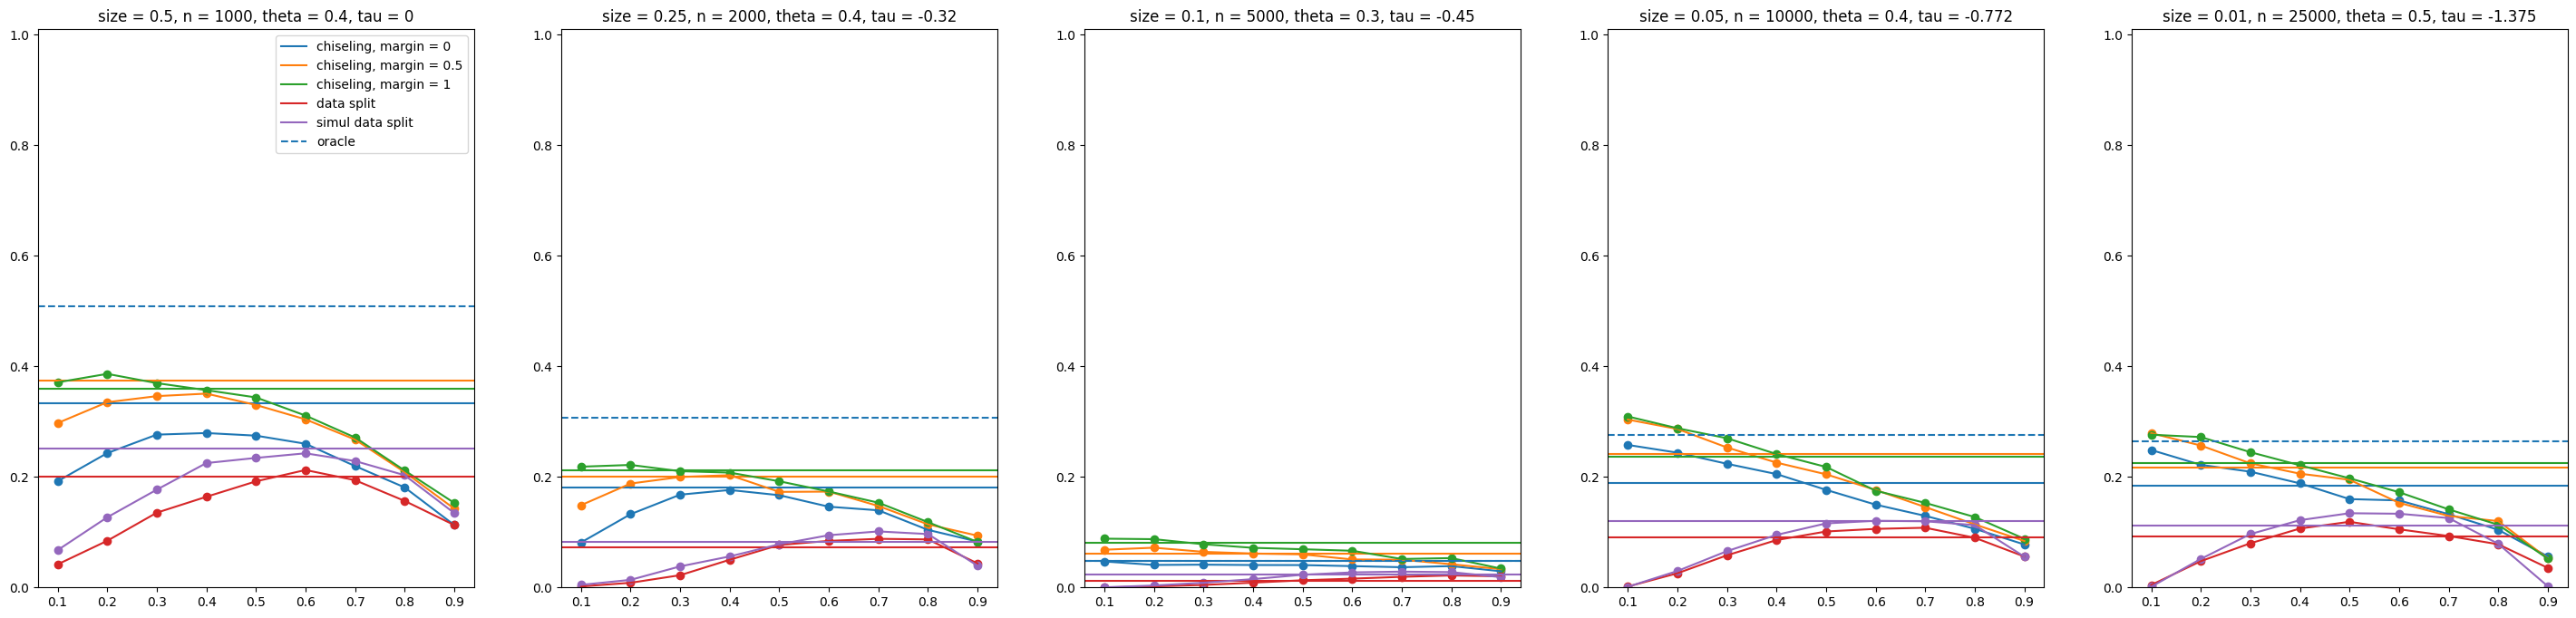

In [11]:
fig, ax = plt.subplots(1,5,figsize=(36,8))

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for (subgroup_size, n, theta, tau) in dgp_settings:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.subgroup_size == subgroup_size]
    sub_res_df = sub_res_df[sub_res_df.n == n]
    sub_res_df = sub_res_df[sub_res_df.theta == theta]
    sub_res_df = sub_res_df[sub_res_df.tau == tau]
    # Chiseling methods
    for margin_width in margin_width_settings:
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        sub_sub_res_df = sub_sub_res_df.sort_values("n_burn_in")
        ax[AX0].plot(sub_sub_res_df.n_burn_in, sub_sub_res_df.norm_subgroup_utility_mean,
                     label="chiseling, margin = {}".format(margin_width))
        last_color = ax[AX0].get_lines()[-1].get_color()
        ax[AX0].scatter(sub_sub_res_df.n_burn_in, sub_sub_res_df.norm_subgroup_utility_mean,
                        color=last_color)
        # Bonferroni combination for chiseling
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        ax[AX0].axhline(sub_sub_res_df.norm_subgroup_utility_mean.values[0], color=last_color)
    # Data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "DataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.norm_subgroup_utility_mean,
                 label="data split")
    last_color = ax[AX0].get_lines()[-1].get_color()
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.norm_subgroup_utility_mean,
                    color=last_color)
    # Bonferroni combination for data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "DataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.norm_subgroup_utility_mean.values[0], color=last_color)
    if PLOT_SIMUL:
        # Simultaneous data splitting
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "SimulDataSplittingStrategy"]
        sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
        ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.norm_subgroup_utility_mean,
                     label="simul data split")
        last_color = ax[AX0].get_lines()[-1].get_color()
        ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.norm_subgroup_utility_mean,
                        color=last_color)
        # Bonferroni combination for simultaneous data splitting
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "SimulDataSplittingStrategy"]
        ax[AX0].axhline(sub_sub_res_df.norm_subgroup_utility_mean.values[0], color=last_color)
    # Oracle
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleStrategy"]
    ax[AX0].axhline(sub_sub_res_df.norm_subgroup_utility_mean.values[0],
                    label="oracle", linestyle="--")
    # Add title
    ax[AX0].set_title("size = {}, n = {}, theta = {}, tau = {}".format(subgroup_size,
                                                                       n,
                                                                       theta,
                                                                       tau))
    # Set ylim
    ax[AX0].set_ylim(0,1+0.01)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

ax[0].legend()

plt.show()

Power

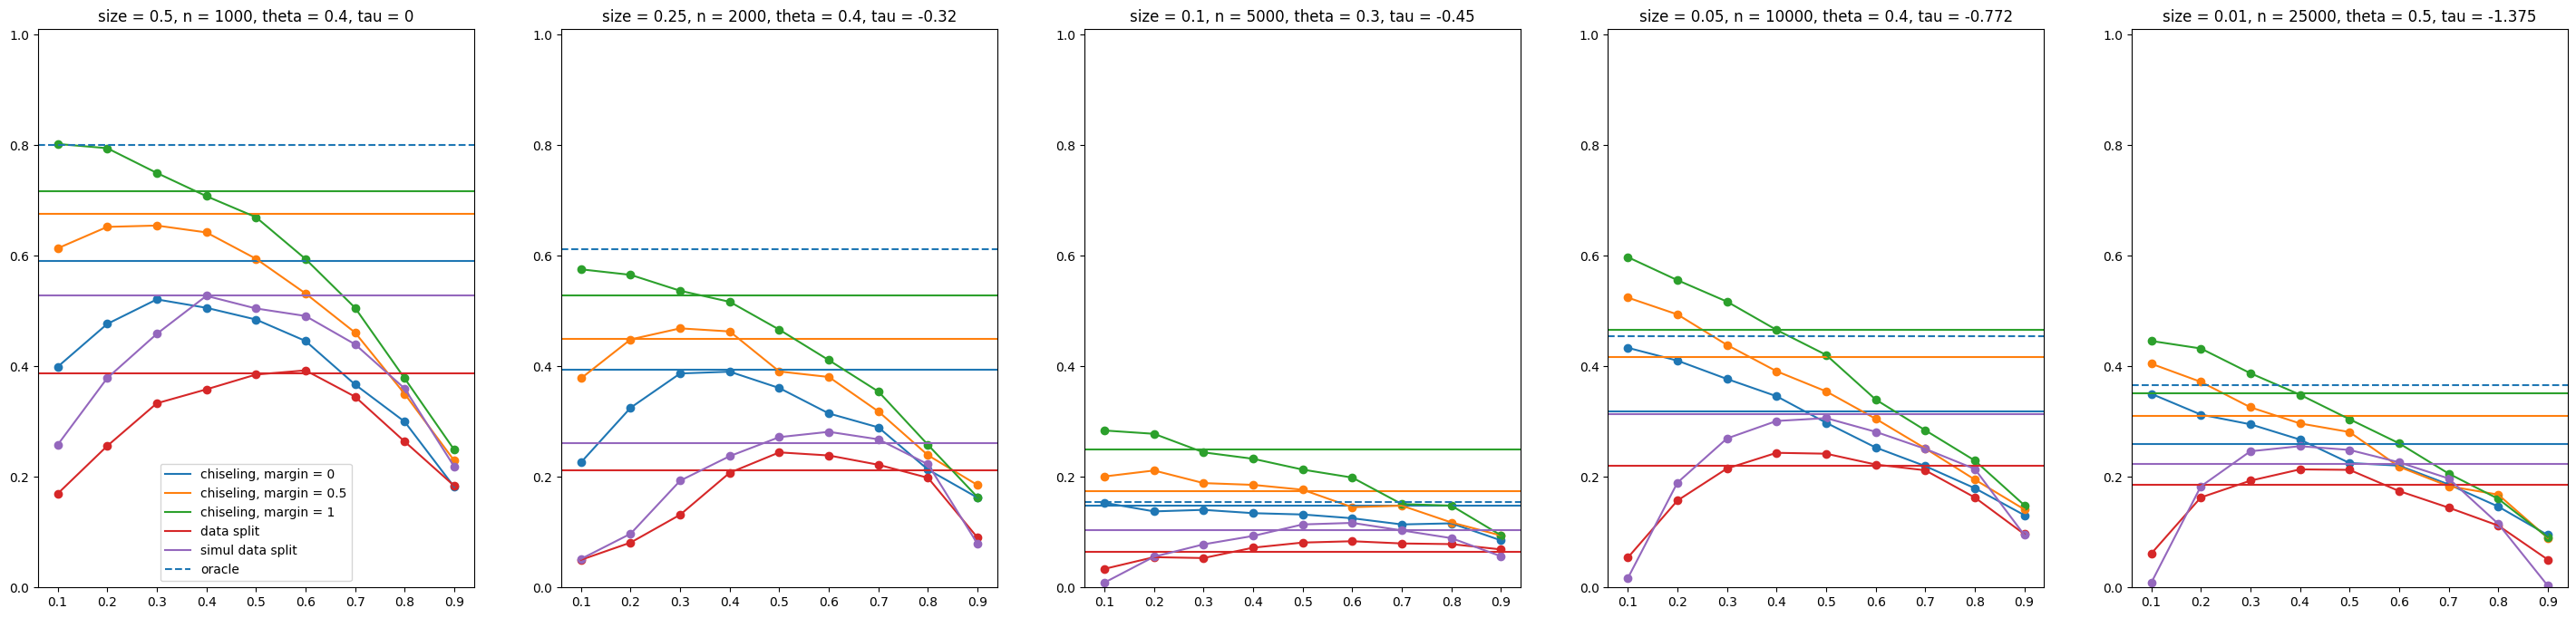

In [12]:
fig, ax = plt.subplots(1,5,figsize=(36,8))

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for (subgroup_size, n, theta, tau) in dgp_settings:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.subgroup_size == subgroup_size]
    sub_res_df = sub_res_df[sub_res_df.n == n]
    sub_res_df = sub_res_df[sub_res_df.theta == theta]
    sub_res_df = sub_res_df[sub_res_df.tau == tau]
    # Chiseling methods
    for margin_width in margin_width_settings:
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        sub_sub_res_df = sub_sub_res_df.sort_values("n_burn_in")
        ax[AX0].plot(sub_sub_res_df.n_burn_in, sub_sub_res_df.rejected_mean,
                     label="chiseling, margin = {}".format(margin_width))
        last_color = ax[AX0].get_lines()[-1].get_color()
        ax[AX0].scatter(sub_sub_res_df.n_burn_in, sub_sub_res_df.rejected_mean,
                        color=last_color)
        # Bonferroni combination for chiseling
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        ax[AX0].axhline(sub_sub_res_df.rejected_mean.values[0], color=last_color)
    # Data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "DataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.rejected_mean,
                 label="data split")
    last_color = ax[AX0].get_lines()[-1].get_color()
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.rejected_mean,
                    color=last_color)
    # Bonferroni combination for data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "DataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.rejected_mean.values[0], color=last_color)
    if PLOT_SIMUL:
        # Simultaneous data splitting
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "SimulDataSplittingStrategy"]
        sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
        ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.rejected_mean,
                     label="simul data split")
        last_color = ax[AX0].get_lines()[-1].get_color()
        ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.rejected_mean,
                        color=last_color)
        # Bonferroni combination for simultaneous data splitting
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "SimulDataSplittingStrategy"]
        ax[AX0].axhline(sub_sub_res_df.rejected_mean.values[0], color=last_color)
    # Oracle
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleStrategy"]
    ax[AX0].axhline(sub_sub_res_df.rejected_mean.values[0],
                    label="oracle", linestyle="--")
    # Add title
    ax[AX0].set_title("size = {}, n = {}, theta = {}, tau = {}".format(subgroup_size,
                                                                       n,
                                                                       theta,
                                                                       tau))
    # Set ylim
    ax[AX0].set_ylim(0,1+0.01)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

ax[0].legend()

plt.show()

### Type I error

In [13]:
res_df["error"] = res_df.rejected & (res_df.subgroup_utility <= 0)

In [14]:
setting_identifiers = ["n", "theta", "tau", "subgroup_size", "strategy", "margin_width",
                       "n_burn_in", "train_ratio", "bonf_strategy"]
error_df = res_df.groupby(setting_identifiers, dropna=False)[["error"]].agg(["mean", "var", "count"])
error_df.columns = ["_".join(c) for c in error_df.columns.to_flat_index()]
error_df = error_df.reset_index()
error_df["error_se"] = np.sqrt(error_df.error_var / error_df.error_count)

error_df = error_df.loc[:,setting_identifiers + ["error_mean", "error_se"]]

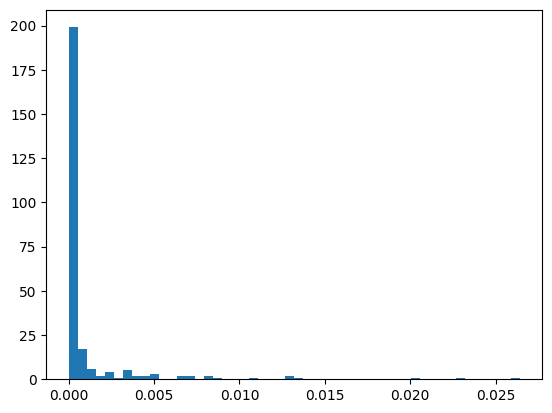

Min = 0.0 / Max = 0.0264


In [15]:
plt.hist(error_df.error_mean.values, bins=50)
plt.show()

print("Min = {} / Max = {}".format(error_df.error_mean.min(), error_df.error_mean.max()))